In [1]:
from pandas import *
from math import *

In [2]:
choice_point = read_csv('./choice_point.csv', index_col=None, encoding='utf-8')
choice_point.head()

,No.,Time,Source,Destination,Protocol,Length,Length.1,Content-Length,Sequence number,Next sequence number,Acknowledgment number,Info
0,49102,186.792387,192.168.7.33,52.30.134.73,HTTP,365,6146,6122,229475,229786,143371,POST /personalization/cl2 HTTP/1.1 (applicati...
1,65388,238.299278,192.168.7.33,52.30.134.73,HTTP,272,6053,6029,285091,285309,161439,POST /personalization/cl2 HTTP/1.1 (applicati...
2,83043,506.497792,192.168.7.33,52.30.134.73,HTTP,1323,5644,5620,374478,375747,201661,POST /personalization/cl2 HTTP/1.1 (applicati...
3,86234,511.524473,192.168.7.33,52.30.134.73,HTTP,631,6412,6388,383702,384279,202866,POST /personalization/cl2 HTTP/1.1 (applicati...


In [23]:
choice_point = choice_point.drop(choice_point.index[3])

In [24]:
choice_point.head()

,No.,Time,Source,Destination,Protocol,Length,Length.1,Content-Length,Sequence number,Next sequence number,Acknowledgment number,Info
0,49102,186.792387,192.168.7.33,52.30.134.73,HTTP,365,6146,6122,229475,229786,143371,POST /personalization/cl2 HTTP/1.1 (applicati...
1,65388,238.299278,192.168.7.33,52.30.134.73,HTTP,272,6053,6029,285091,285309,161439,POST /personalization/cl2 HTTP/1.1 (applicati...
2,83043,506.497792,192.168.7.33,52.30.134.73,HTTP,1323,5644,5620,374478,375747,201661,POST /personalization/cl2 HTTP/1.1 (applicati...


In [27]:
choice_time = [floor(choice_point.Time[i]) for i in range(3)]
choice_time

[186, 238, 506]

In [29]:
app_data = read_csv('./app_data.csv', index_col=None, encoding='utf-8')
app_data.head()

,No.,Time,Source,Destination,Protocol,Length,Length.1,Content-Length,Sequence number,Next sequence number,Acknowledgment number,Info
0,17468,34.125173,192.168.7.33,45.57.50.133,HTTP,713,654,NaN,611,1270,3208,GET /?o=AQE8zVRPw5IuxJItl8fXccTxZSOAf9eQV_2QnC...
1,17481,34.196030,192.168.7.33,45.57.50.133,HTTP,730,671,NaN,611,1287,3208,GET /range/0-114851?o=AQE8zVRPw5IuxJIinMXfdMf2...
2,17482,34.196114,192.168.7.33,45.57.50.133,HTTP,728,669,NaN,611,1285,3208,GET /range/0-114851?o=AQE8zVRPw5IuxJIsnsfYcML-...
3,17485,34.197597,45.57.50.133,192.168.7.33,TLSv1.2,646,587,NaN,3514,4106,1270,[SSL segment of a reassembled PDU]
4,17509,34.228473,45.57.50.133,192.168.7.33,TLSv1.2,1514,16408,NaN,20166,21626,1270,[SSL segment of a reassembled PDU] [TCP segmen...


In [31]:
app_data_interest = app_data[app_data.Time >= choice_time[0]]

In [32]:
app_data_interest.head()

,No.,Time,Source,Destination,Protocol,Length,Length.1,Content-Length,Sequence number,Next sequence number,Acknowledgment number,Info
2754,47459,186.003589,45.57.50.133,192.168.7.33,TLSv1.2,1514,13236,NaN,1210671,1212131,16306,Application Data [TCP segment of a reassembled...
2755,47461,186.003591,45.57.50.133,192.168.7.33,TLSv1.2,709,3469,NaN,1213591,1214246,16306,Application Data
2756,47473,186.005392,45.57.50.133,192.168.7.33,TLSv1.2,1514,12315,NaN,1804242,1805702,13350,Application Data [TCP segment of a reassembled...
2757,47485,186.005492,45.57.50.133,192.168.7.33,TLSv1.2,1514,16408,NaN,1820302,1821762,13350,Application Data [TCP segment of a reassembled...
2758,47511,186.015415,45.57.50.133,192.168.7.33,TLSv1.2,1514,16408,NaN,1798488,1799948,11101,Application Data [TCP segment of a reassembled...


In [37]:
a = [0]
b= []
a

[0]

In [38]:
start_time = choice_time[0]
b.append(start_time)
i = 0
for _,packet in app_data_interest.iterrows():
    curr_time = floor(packet.Time)
    if curr_time > start_time:
        i += 1
        a.append(0)
        b.append(curr_time)
        start_time = curr_time
    a[i]+= 1
    

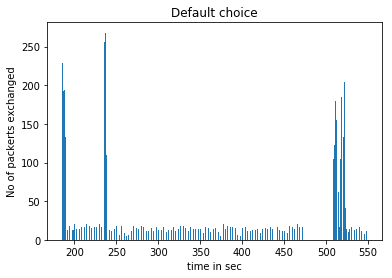

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

# plt.hist(a, bins=6)
plt.bar(b, a)
plt.ylabel('No of packerts exchanged')
plt.xlabel('time in sec')
plt.title("Default choice")
plt.show()